In [1]:
from tensorflow.keras.layers import Dense, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
if tf.config.list_physical_devices('GPU'):
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    batch_size = 1024
    print('Compute dtype: %s' % policy.compute_dtype)
    print('Variable dtype: %s' % policy.variable_dtype)
else:
    print('The model will run on a CPU')
    batch_size = 512

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Compute dtype: float16
Variable dtype: float32


In [3]:
# Train with augumentation
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
numclasses = 10
inputshape = (32, 32, 3)

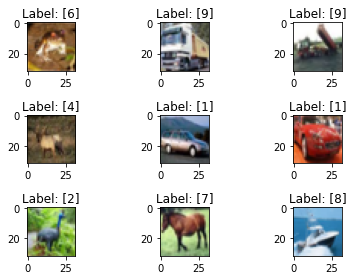

In [4]:
for i in range(9):
    pyplot.subplot(3,3,i+1)
    pyplot.tight_layout()
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.title("Label: {}".format(y_train[i]))
pyplot.show()

In [5]:
n_train_images = X_train.shape[0]
n_test_images = X_test.shape[0]

y_train = to_categorical(y_train, numclasses)
y_test = to_categorical(y_test, numclasses)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=0.1,
        brightness_range=[0.7, 1.3],
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255,
                                rescale=1./255,
                                rotation_range=0.1,
                                brightness_range=[0.7, 1.3],
                                horizontal_flip=True)

train_generator = train_datagen.flow(
        X_train,
        y=y_train,
        batch_size=batch_size)

test_generator = test_datagen.flow(
        X_test,
        y=y_test,
        batch_size=batch_size)

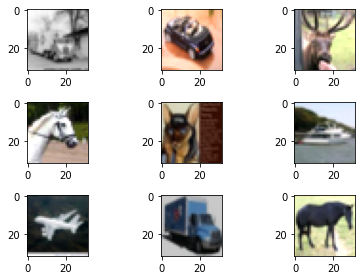

In [7]:
datageneration = ImageDataGenerator(rescale=1./255,
                                    rotation_range=0.1,
                                    brightness_range=[0.7, 1.3],
                                    horizontal_flip=True)

for X_batch, y_batch in datageneration.flow(X_train, y_train, batch_size=9):

    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.tight_layout()
        pyplot.imshow(X_batch[i].reshape(32, 32, 3), cmap=pyplot.get_cmap('gray'))

    pyplot.show()
    break

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=inputshape, pooling='avg')

In [7]:
x = base_model.output
output = Dense(numclasses, activation='softmax', dtype='float32')(x)

In [8]:
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.summary()

In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

In [9]:
he_normal = tf.keras.initializers.he_normal()

In [10]:
for layer in model.layers:
    if layer.name.endswith('_bn'):
      new_weights = [
          he_normal(layer.weights[0].shape),
          tf.zeros(layer.weights[1].shape),
          tf.zeros(layer.weights[2].shape),
          tf.ones(layer.weights[3].shape)]

      layer.set_weights(new_weights)
      layer.trainable = True
    else:
      layer.trainable = False

In [11]:
model.compile(optimizer=Adam(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])

In [12]:
callbacks = [
    EarlyStopping(patience=20, monitor='val_accuracy', mode="auto"),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, monitor='val_accuracy', mode='max', verbose=1),
    ModelCheckpoint('model.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)
]

In [13]:
results = model.fit(train_generator,
          steps_per_epoch=n_train_images // batch_size,
          validation_data=test_generator,
          validation_steps=n_test_images // batch_size,
          epochs=500,
          callbacks=callbacks)

Epoch 1/500
48/48 [==============================] - 38s 606ms/step - loss: 1.9309 - accuracy: 0.2700 - val_loss: 2.3493 - val_accuracy: 0.0996

Epoch 00001: val_accuracy improved from -inf to 0.09961, saving model to model.h5
Epoch 2/500
48/48 [==============================] - 28s 575ms/step - loss: 1.2108 - accuracy: 0.5631 - val_loss: 2.3559 - val_accuracy: 0.0995

Epoch 00002: val_accuracy did not improve from 0.09961
Epoch 3/500
48/48 [==============================] - 28s 573ms/step - loss: 1.0448 - accuracy: 0.6281 - val_loss: 2.3946 - val_accuracy: 0.1008

Epoch 00003: val_accuracy improved from 0.09961 to 0.10080, saving model to model.h5
Epoch 4/500
48/48 [==============================] - 28s 573ms/step - loss: 0.9563 - accuracy: 0.6620 - val_loss: 2.4163 - val_accuracy: 0.1006

Epoch 00004: val_accuracy did not improve from 0.10080
Epoch 5/500
48/48 [==============================] - 28s 577ms/step - loss: 0.9320 - accuracy: 0.6682 - val_loss: 2.4134 - val_accuracy: 0.1013

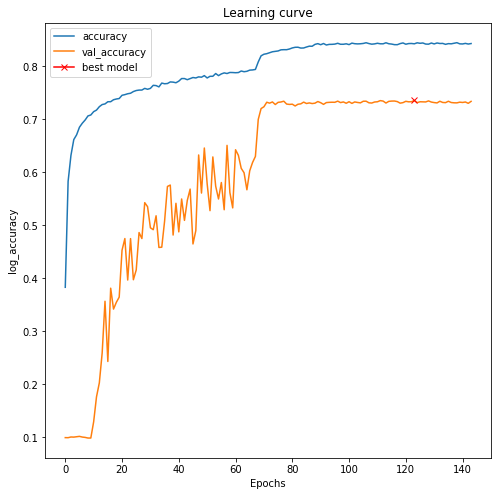

In [14]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_accuracy")
plt.legend();

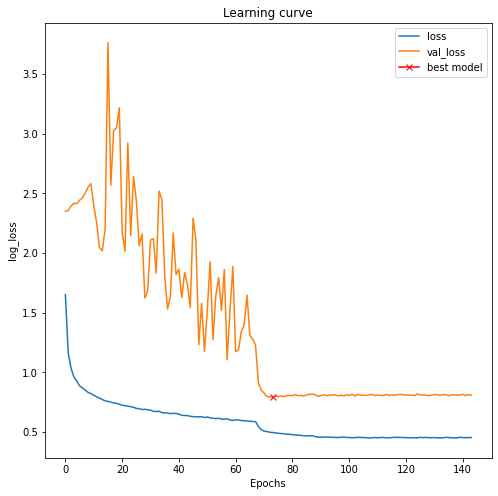

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();